<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Datenaufbereitung" data-toc-modified-id="Datenaufbereitung-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Datenaufbereitung</a></span></li><li><span><a href="#Datenauswertung" data-toc-modified-id="Datenauswertung-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Datenauswertung</a></span><ul class="toc-item"><li><span><a href="#Allgemeines" data-toc-modified-id="Allgemeines-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Allgemeines</a></span></li><li><span><a href="#Stimmverhalten-der-Fraktionen" data-toc-modified-id="Stimmverhalten-der-Fraktionen-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Stimmverhalten der Fraktionen</a></span></li><li><span><a href="#Stimmverhalten-der-Parlamentsmitglieder" data-toc-modified-id="Stimmverhalten-der-Parlamentsmitglieder-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Stimmverhalten der Parlamentsmitglieder</a></span><ul class="toc-item"><li><span><a href="#Mohamed-Hamdaoui" data-toc-modified-id="Mohamed-Hamdaoui-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Mohamed Hamdaoui</a></span></li><li><span><a href="#Erich-Hess" data-toc-modified-id="Erich-Hess-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Erich Hess</a></span></li><li><span><a href="#Michel-Seiler" data-toc-modified-id="Michel-Seiler-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Michel Seiler</a></span></li><li><span><a href="#Christoph-Zimmerli" data-toc-modified-id="Christoph-Zimmerli-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Christoph Zimmerli</a></span></li></ul></li></ul></li></ul></div>

In diesem Notebook werden die zuvor aufbereiteten Abstimmungsdaten ausgewertet. 

## Datenaufbereitung

In [24]:
# Die nötigen Bibliotheken werden importiert. 
import pandas as pd
import re
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import config
from datawrapper import Datawrapper
dw = Datawrapper(access_token = config.dw_token)

In [25]:
# Die Daten werden eingelesen. 
df = pd.read_csv('daten/be_grossrat_abstimmungen.csv', index_col='Unnamed: 0', low_memory=False)
df['datetime'] = pd.to_datetime(df['datetime'])

In [26]:
# Drei Personen werden ausgeschlossen.
df = df[df['nachname'] != 'Hamdaoui']
df = df[df['nachname'] != 'Seiler']
df = df[df['nachname'] != 'Wüthrich']

In [27]:
# Welche Abstimmungen haben mehr als 160 Teilnehmende?  
df_temp = df.groupby(by=['geschäftsname', 'dateiname', 'register'])[['stimme']].count()
df_temp = df_temp[df_temp['stimme'] > 160]
df_temp

,,,stimme
geschäftsname,dateiname,register,
79 2020.RRGR.231_14,07) 17.03.21 Frühlingssession 2021.xlsx,Tabelle1,605
80 2020.RRGR.232_14,07) 17.03.21 Frühlingssession 2021.xlsx,Tabelle1,307


In [28]:
# Diese offensichtlich fehlerhaft eingelesenen Abstimmungen werden entfernt. 
df = df[(df['geschäftsname'] != df_temp.index[0][0]) & (df['dateiname'] != df_temp.index[0][1]) & (df['register'] != df_temp.index[0][2])]
df = df[(df['geschäftsname'] != df_temp.index[1][0]) & (df['dateiname'] != df_temp.index[1][1]) & (df['register'] != df_temp.index[1][2])]

In [30]:
# Für jede Vorlage wird die "Parteilinie" bestimmt. 
df_parteilinie = df.groupby(by=['geschäftsname', 'dateiname', 'register', 'partei'])['stimme'].value_counts().to_frame()
df_parteilinie = df_parteilinie.unstack()
df_parteilinie['stimme'] = df_parteilinie['stimme'].fillna(0)

def linienfinder(ja, nein, enthaltung, abwesend): 
    t = ja + nein
    if ja / t >= 0.666666:
        return 'ja'
    elif nein / t >= 0.666666:
        return 'nein'
    elif enthaltung / t >= 0.666666:
        return 'enthaltung'
    else:
        return 'unentschieden'
    
for i, r in tqdm(df_parteilinie.iterrows(),total=len(df_parteilinie), leave=False):
    l = linienfinder(r['stimme']['ja'], r['stimme']['nein'], r['stimme']['enthaltung'], r['stimme']['abwesend'])
    df_parteilinie.at[i, 'linie'] = l
df_parteilinie = df_parteilinie[['linie']].reset_index()

df_temp = df_parteilinie.groupby(by=['geschäftsname', 'dateiname', 'register', 'partei']).sum()[['linie']]
df_temp = df_temp.unstack()
df_temp.columns = [x[2] for x in df_temp.columns]
df_parteilinie = df_temp.copy()
df_parteilinie.head()

Die Mitte   EDU   EVP  \
geschäftsname dateiname                  register                           
#0000.0000_0  Frühlingssession 2019.xlsx 4.03.2019         ja    ja  nein   
              Frühlingssession 2020.xlsx 2.03.2020         ja    ja    ja   
                                         4.03.2020       nein    ja    ja   
              Herbstsession 2019.xlsx    2.09.2019         ja    ja    ja   
              Wintersession 2018.xlsx    19.11.2018      nein  nein    ja   

                                                      FDP Grüne    SP  \
geschäftsname dateiname                  register                       
#0000.0000_0  Frühlingssession 2019.xlsx 4.03.2019     ja  nein  nein   
              Frühlingssession 2020.xlsx 2.03.2020     ja    ja    ja   
                                         4.03.2020     ja    ja    ja   
              Herbstsession 2019.xlsx    2.09.2019     ja    ja    ja   
              Wintersession 2018.xlsx    19.11.2018  nein    ja    ja   

                                                               SVP   glp  
geschäftsname dateiname                  register                         
#0000.0000_0  Frühlingssession 2019.xlsx 4.03.2019              ja    ja  
              Frühlingssession 2020.xlsx 2.03.2020            nein    ja  
                                         4.03.2020   unentschieden    ja  
              Herbstsession 2019.xlsx    2.09.2019              ja    ja  
              Wintersession 2018.xlsx    19.11.2018           nein  nein

In [31]:
# Ein Datensatz zur "Linientreue" der einzelnen Parlamentarier wird erstellt. 
df_politiker = df.drop_duplicates(subset=['nachname', 'vorname', 'partei'])[['nachname', 'vorname', 'partei', 'wahlkreis', 'sprache']]
df_politiker = df_politiker.dropna(subset=['nachname', 'vorname'])
df_politiker.reset_index(drop=True)

# Nun wird berechnet, wie linientreu die Parlamentarier sind. 
for i, r in tqdm(df_politiker.iterrows(), total=len(df_politiker)):
    linientreu = 0
    abgewichen = 0

    df_temp = df[(df['vorname'] == r['vorname']) & (df['nachname'] == r['nachname']) & (df['partei'] == r['partei'])]

    for j, s in df_temp.iterrows():
        eingelegt = s['stimme']
        parteilinie = df_parteilinie.loc[s['geschäftsname'], s['dateiname'], s['register']][s['partei']]
        
        if (parteilinie == 'ja' or parteilinie == 'nein' or parteilinie == 'enthaltung') and (eingelegt == 'ja' or eingelegt == 'nein' or eingelegt == 'enthaltung'):
            if eingelegt == parteilinie:
                linientreu += 1
            elif eingelegt != parteilinie:
                abgewichen += 1
            
    df_politiker.at[i, 'linientreu'] = linientreu
    df_politiker.at[i, 'abgewichen'] = abgewichen

df_politiker['linientreue'] = 100 * df_politiker['linientreu'] / df_politiker[['linientreu', 'abgewichen']].sum(axis=1)
df_politiker.head()

100%|██████████| 186/186 [01:47<00:00,  1.73it/s]


,nachname,vorname,partei,wahlkreis,sprache,linientreu,abgewichen,linientreue
0,Aebi,Markus,SVP,Emmental,d,1739.0,160.0,91.574513
1,Aebischer,Verena,SVP,Mittelland-Süd,d,2058.0,49.0,97.674419
2,Amstutz,Madeleine,SVP,Thun,d,2103.0,45.0,97.905028
3,Augstburger,Ueli,SVP,Mittelland-Süd,d,1863.0,76.0,96.080454
4,Benoit,Roland,SVP,Berner Jura,f,1928.0,148.0,92.870906


In [32]:
# Ein Datensatz zu den Geschäften wird erstellt. 
df_geschäfte = df.groupby(by=['geschäftsname', 'dateiname', 'register', 'partei'])['stimme'].value_counts().to_frame()
df_geschäfte = df_geschäfte.unstack()
df_geschäfte = df_geschäfte.fillna(0)
df_geschäfte.columns = [x[1] for x in df_geschäfte.columns]
df_geschäfte.head()

abwesend  \
geschäftsname dateiname                  register  partei                
#0000.0000_0  Frühlingssession 2019.xlsx 4.03.2019 Die Mitte       1.0   
                                                   EDU             0.0   
                                                   EVP             0.0   
                                                   FDP             0.0   
                                                   Grüne           0.0   

                                                              enthaltung  \
geschäftsname dateiname                  register  partei                  
#0000.0000_0  Frühlingssession 2019.xlsx 4.03.2019 Die Mitte         0.0   
                                                   EDU               0.0   
                                                   EVP               0.0   
                                                   FDP               0.0   
                                                   Grüne             1.0   

                                                                ja  nein  
geschäftsname dateiname                  register  partei                 
#0000.0000_0  Frühlingssession 2019.xlsx 4.03.2019 Die Mitte  11.0   0.0  
                                                   EDU         5.0   0.0  
                                                   EVP         2.0   8.0  
                                                   FDP        20.0   0.0  
                                                   Grüne       0.0  13.0

## Datenauswertung

### Allgemeines

In [58]:
# Wie viele Abstimmungen sind verzeichnet? 
len(df.groupby(by=['geschäftsname', 'dateiname', 'register']).count().reset_index())

2241

In [59]:
# Wie viele Parlamentarierinnen und Parlamentarier sind verzeichnet? 
df_temp = df.copy()
df_temp['vor-nachname'] = df['nachname'] + '-' + df['vorname']
len(df_temp['vor-nachname'].unique())

185

In [60]:
# Wie viel mal wurde der Abstimmungsknopf gedrückt? Wie viele Abwesenheiten und Enthaltungen sind verzeichnet?
# Achtung: Die Abwesenheiten wurden von den Abstimmungsanlagen nicht einheitlich erfasst.
df['stimme'].value_counts()

ja            217969
nein           91856
abwesend       23482
enthaltung      5727
Name: stimme, dtype: int64

### Stimmverhalten der Fraktionen

In [61]:
# Wie oft gab es eine Fraktionslinie? Wie oft nicht? 
parteien = df['partei'].unique()
df_parteilinie_auswertung = pd.DataFrame(index=['ja', 'nein', 'enthaltung', 'unentschieden'])

for p in parteien:
    try:
        df_parteilinie_auswertung = pd.merge(df_parteilinie_auswertung, df_parteilinie[p].value_counts().to_frame(), left_index=True, right_index=True, how='left')
    except:
        pass
df_parteilinie_auswertung= df_parteilinie_auswertung.transpose()
df_parteilinie_auswertung

,ja,nein,enthaltung,unentschieden
SVP,1440.0,717.0,NaN,84.0
SP,1582.0,589.0,2.0,68.0
FDP,1551.0,631.0,NaN,59.0
Grüne,1587.0,587.0,3.0,64.0
Die Mitte,1551.0,599.0,NaN,91.0
glp,1655.0,533.0,12.0,41.0
EVP,1661.0,490.0,5.0,85.0
EDU,1583.0,600.0,8.0,50.0


In [62]:
# Wie oft gab es eine Fraktionslinie, wie oft nicht? Grafik im Datawrapper
df_temp = df_parteilinie_auswertung
df_temp = df_temp[df_temp.index != 'fraktionslos']
df_temp = df_temp[['ja', 'nein', 'unentschieden', 'enthaltung']]
df_temp = df_temp.sort_values(by='unentschieden')

dw_id = 'igNLL'
dw.add_data(chart_id=dw_id, data=df_temp.reset_index())

print(re.sub('\/\d+\/', '/', dw.get_iframe_code(chart_id=dw_id)))

# Die Grafk wird publiziert. 
dw.publish_chart(chart_id=dw_id)

<iframe title="In der Regel stimmt die Fraktion einheitlich" aria-label="Balken (gestapelt)" id="datawrapper-chart-igNLL" src="https://datawrapper.dwcdn.net/igNLL/" scrolling="no" frameborder="0" style="border: none;" width="600" height="340"></iframe>


In [63]:
# Wie oft gab es eine Fraktionslinie, wie oft nicht? Grafik im Datawrapper
df_temp = pd.DataFrame()

for p in ['Die Mitte', 'EDU', 'EVP', 'FDP', 'Grüne', 'SP', 'SVP', 'glp']:
    df_temp = df_temp.append(df_parteilinie[p].value_counts().to_frame().transpose())
    
df_temp['enthaltung'] = df_temp['enthaltung'].fillna(0)    

df_temp['klare Parteilinie'] = df_temp['ja'] + df_temp['nein'] + df_temp['enthaltung']
df_temp['keine Parteilinie'] = df_temp['unentschieden']
df_temp = df_temp[[x for x in df_temp.columns if 'Parteilinie' in x]]
df_temp['klare Parteilinie'] = df_temp['klare Parteilinie'].astype('int')
df_temp = df_temp.sort_values(by='keine Parteilinie', ascending=True)

dw_id = '3UN8G'
dw.add_data(chart_id=dw_id, data=df_temp.reset_index())

print(re.sub('\/\d+\/', '/', dw.get_iframe_code(chart_id=dw_id)))

# Die Grafk wird publiziert. 
dw.publish_chart(chart_id=dw_id)

<iframe title="In der Regel stimmt die Fraktion einheitlich" aria-label="Balken (gestapelt)" id="datawrapper-chart-3UN8G" src="https://datawrapper.dwcdn.net/3UN8G/" scrolling="no" frameborder="0" style="border: none;" width="600" height="340"></iframe>


In [64]:
'''# Wie hoch ist für jedes Geschäft der Prozentsatz der Fraktionsmitglieder, der gleich stimmt? 
df_temp = df.copy()
df_temp['vor-nachname'] = df_temp['vorname'] + ' ' + df_temp['nachname']
df_temp = df_temp.groupby(by=['geschäftsname', 'dateiname', 'register', 'partei'])['stimme'].value_counts().to_frame().unstack()
df_temp.columns = [x[1] for x in df_temp.columns] 
del df_temp['abwesend'] 
for c in df_temp.columns:
    df_temp[c] = df_temp[c].fillna(0)
    df_temp[c] = df_temp[c].astype('int')
    df_temp[c + '_rel'] = 100 * df_temp[c] / df_temp[['ja', 'nein', 'enthaltung']].sum(axis=1)
df_temp = df_temp[[x for x in df_temp.columns if 'rel' in x]]
df_temp.reset_index().groupby(by='partei')[['ja_rel', 'nein_rel', 'enthaltung_rel']].mean()'''

"# Wie hoch ist für jedes Geschäft der Prozentsatz der Fraktionsmitglieder, der gleich stimmt? \ndf_temp = df.copy()\ndf_temp['vor-nachname'] = df_temp['vorname'] + ' ' + df_temp['nachname']\ndf_temp = df_temp.groupby(by=['geschäftsname', 'dateiname', 'register', 'partei'])['stimme'].value_counts().to_frame().unstack()\ndf_temp.columns = [x[1] for x in df_temp.columns] \ndel df_temp['abwesend'] \nfor c in df_temp.columns:\n    df_temp[c] = df_temp[c].fillna(0)\n    df_temp[c] = df_temp[c].astype('int')\n    df_temp[c + '_rel'] = 100 * df_temp[c] / df_temp[['ja', 'nein', 'enthaltung']].sum(axis=1)\ndf_temp = df_temp[[x for x in df_temp.columns if 'rel' in x]]\ndf_temp.reset_index().groupby(by='partei')[['ja_rel', 'nein_rel', 'enthaltung_rel']].mean()"

In [65]:
# Die Fraktionslinien in Prozent. 
for i in ['ja', 'nein', 'enthaltung', 'unentschieden']:
    df_parteilinie_auswertung[i + '_rel'] = 100 * df_parteilinie_auswertung[i] / df_parteilinie_auswertung.sum(axis=1)
df_parteilinie_auswertung[[x for x in df_parteilinie_auswertung.columns if 'rel' in x]]

,ja_rel,nein_rel,enthaltung_rel,unentschieden_rel
SVP,64.257028,31.102822,NaN,3.595337
SP,70.593485,25.480259,0.085577,2.909515
FDP,69.210174,27.313532,NaN,2.524039
Grüne,70.816600,25.391288,0.128358,2.738160
Die Mitte,69.210174,25.928377,NaN,3.895317
glp,73.850959,23.025240,0.513286,1.753343
EVP,74.118697,21.165221,0.214015,3.637923
EDU,70.638108,25.955620,0.342232,2.138639


In [66]:
# Bei welchen Geschäften konnten sich die Fraktionen nicht auf eine Linie einigen? 
for p in [x for x in df['partei'].unique() if x != 'fraktionslos']:
    df_temp = df_parteilinie[df_parteilinie[p] == 'unentschieden'][p]
    print(p)
    for i in df_temp.index.tolist():
        print(i)
    print('\n---\n\n')

SVP
('#0000.0000_0', 'Frühlingssession 2020.xlsx', '4.03.2020')
('#0000.0000_2', 'Frühlingssession 2020.xlsx', '2.03.2020')
('#2014.STA.20196_3', 'Herbstsession 2018.xlsx', '4.09.2018')
('#2014.STA.20196_5', 'Herbstsession 2018.xlsx', '4.09.2018')
('#2016.STA.25266_3', 'Frühlingssession 2019.xlsx', '5.03.2019')
('#2017.RRGR.580_0', 'Sommersession 2018.xlsx', '6.06.2018')
('#2017.RRGR.721_9', 'Sommersession 2018.xlsx', '11.06.2018')
('#2017.RRGR.737_7', 'Sommersession 2018.xlsx', '5.06.2018')
('#2018.BVE.725_24', 'Frühlingssession 2019.xlsx', '6.03.2019')
('#2018.JGK.410_0', 'Herbstsession 2019.xlsx', '12.09.2019')
('#2018.RRGR.195_7', 'Wintersession 2018.xlsx', '22.11.2018')
('#2018.RRGR.201_8', 'Herbstsession 2018.xlsx', '6.09.2018')
('#2018.RRGR.228_0', 'Wintersession 2018.xlsx', '22.11.2018')
('#2018.RRGR.228_1', 'Wintersession 2018.xlsx', '22.11.2018')
('#2018.RRGR.273_0', 'Sommersession 2018.xlsx', '5.06.2018')
('#2018.RRGR.356_14', 'Herbstsession 2018.xlsx', '6.09.2018')
('#2018.

In [67]:
# In welcher Fraktion gibt es am meisten, in welchen am wenigsten Abweichlerinnen und Abweichler?
df_politiker.groupby(by='partei')[['linientreue']].mean().sort_values(by='linientreue')

,linientreue
partei,
SVP,94.902611
Grüne,95.016078
glp,95.314889
SP,95.323298
EVP,95.503839
Die Mitte,95.831604
EDU,96.713772
FDP,97.105368


In [45]:
# Ergibt sich evtl. ein regionales Muster hinter Abweichungen? Z.B. Oberländer Grossrätinnen und Grossräte, Emmental usw? (evtl. kann ich diese Frage dann bei der Analyse deiner Auswertungen beantworten).
df_temp = df_politiker.groupby(by='wahlkreis')[['linientreue']].mean().sort_values(by='linientreue')
df_temp

,linientreue
wahlkreis,
Bern,94.652503
Berner Jura,95.020028
Thun,95.062557
Biel-Seeland,95.516657
Biel-Bienne - Seeland,95.566318
Mittelland-Nord,95.696810
Oberland,95.761482
Mittelland-Süd,95.855117
Emmental,95.967331


In [46]:
# Karte zu den reginalen Muster. 
dw_id = '4HybE'
dw.add_data(chart_id=dw_id, data=df_temp.reset_index())

print(re.sub('\/\d+\/', '/', dw.get_iframe_code(chart_id=dw_id)))

# Die Grafk wird publiziert. 
dw.publish_chart(chart_id=dw_id)

<iframe title="Wie oft stimmen die Parlamentarier mit ihrer Fraktion?" aria-label="Karte" id="datawrapper-chart-4HybE" src="https://datawrapper.dwcdn.net/4HybE/" scrolling="no" frameborder="0" style="border: none;" width="600" height="704"></iframe>


In [47]:
# Abweichler nach Sprache. 
df_temp = df_politiker.groupby(by='sprache')[['linientreue']].mean().sort_values(by='linientreue')
df_temp

,linientreue
sprache,
f,95.271962
d,95.527894


In [48]:
# Abweichler nach Alter. 

from datetime import datetime, timedelta
heute = datetime.now()

# Die Daten der Grossräte werden eingelesen. 
df_grossräte = pd.read_csv('daten/grossrat.csv', index_col='Unnamed: 0')
df_grossräte['geburtstag'] = pd.to_datetime(df_grossräte['geburtstag'])

# Das Alter wird berechnet. 
df_grossräte['alter'] = df_grossräte['geburtstag'].apply(lambda x: (heute - x).total_seconds() / 60 / 60 / 24 / 365)

# Das Alter wird dem Datensatz hinzugefügt. 
df_temp = pd.merge(df_politiker, df_grossräte[['vorname', 'nachname', 'partei', 'alter']], left_on=['vorname', 'nachname', 'partei'], right_on=['vorname', 'nachname', 'partei'], how='left')
df_temp

df_temp['alterskat'] = pd.cut(df_temp['alter'], bins=5)
df_temp.groupby(by='alterskat')[['linientreue']].mean().sort_index()

,linientreue
alterskat,
"(28.23, 37.316]",95.751937
"(37.316, 46.356]",94.192158
"(46.356, 55.396]",95.761167
"(55.396, 64.436]",95.760840
"(64.436, 73.476]",94.762850


In [49]:
# Abweichlinnen und Abweichler. 
df_temp = pd.merge(df_politiker, df_grossräte[['nachname', 'vorname', 'geschlecht']], left_on=['nachname', 'vorname'], right_on=['nachname', 'vorname'], how='left')
df_temp.groupby(by=['partei', 'geschlecht'])['linientreue'].mean().to_frame()

linientreue
partei    geschlecht             
Die Mitte m             95.796905
          w             95.279752
EDU       m             96.446743
          w             97.781885
EVP       m             94.492636
          w             96.852110
FDP       m             97.097404
          w             97.143194
Grüne     m             94.771278
          w             95.464878
SP        m             95.051448
          w             95.501045
SVP       m             94.640549
          w             95.903994
glp       m             95.195542
          w             96.054752

**Fazit:** Die Politikerinnen sind ganz leicht linientreuer als ihre männlichen Kollegen. 

In [50]:
# Todo: Bei welchen Geschäften wichen am meisten Personen von der Parteilinie ab? Bei welchen wich niemand ab?

### Stimmverhalten der Parlamentsmitglieder

In [51]:
# Welche Politiker politisierten am meisten auf Parteilinie, bzw. wichen nie oder selten von der 2/3-Mehrheit ab?
# Berücksichtigt werden bloss Politiker, bei denen über 500 Abstimmungen verzeichnet sind. 
df_temp = df_politiker.sort_values(by='linientreue', ascending=False)
df_temp['summe'] = df_temp[['linientreu', 'abgewichen']].sum(axis=1)
df_temp = df_temp[df_temp['summe'] >= 500].head(30)
df_temp

,nachname,vorname,partei,wahlkreis,sprache,linientreu,abgewichen,linientreue,summe
100,Zimmerli,Christoph,FDP,Bern,d,1955.0,15.0,99.238579,1970.0
123,Gerber,Peter,Die Mitte,Biel-Seeland,d,2054.0,17.0,99.179141,2071.0
93,Kohler,Hans-Peter,FDP,Mittelland-Süd,d,1890.0,25.0,98.694517,1915.0
98,Teuscher-Abts,Marianne,FDP,Oberaargau,d,1431.0,19.0,98.689655,1450.0
25,Salzmann,Peter,SVP,Mittelland-Nord,d,1910.0,26.0,98.657025,1936.0
161,Tanner,Ernst,EDU,Emmental,d,2095.0,31.0,98.541863,2126.0
121,Eichenberger,Beatrice,Die Mitte,Mittelland-Süd,d,1798.0,28.0,98.466594,1826.0
86,Arn,Daniel,FDP,Mittelland-Nord,d,1981.0,34.0,98.312655,2015.0
56,Funiciello,Tamara,SP,Bern,d,694.0,12.0,98.300283,706.0
196249,Steiner,Hanspeter,EVP,Mittelland-Nord,d,960.0,17.0,98.259980,977.0


In [52]:
# Welche Politiker wichen am häufigsten von der Parteilinie ab? 
df_temp = df_politiker.sort_values(by='linientreue', ascending=True)
df_temp['summe'] = df_temp[['linientreu', 'abgewichen']].sum(axis=1)
df_temp = df_temp[df_temp['summe'] >= 500]
df_temp.head(20)

,nachname,vorname,partei,wahlkreis,sprache,linientreu,abgewichen,linientreue,summe
14,Hess,Erich,SVP,Bern,d,921.0,162.0,85.041551,1083.0
24,Ruchti,Fritz,SVP,Biel-Seeland,d,1552.0,252.0,86.031042,1804.0
196334,Marti,Jürg,SVP,Thun,d,861.0,100.0,89.594173,961.0
73,Siegenthaler,Peter,SP,Thun,d,1574.0,167.0,90.407812,1741.0
44,Schilt,Walter,SVP,Mittelland-Nord,d,1877.0,196.0,90.545104,2073.0
39,Geissbühler-Strupler,Sabina,SVP,Mittelland-Nord,d,1879.0,188.0,90.904693,2067.0
15,Hofer,Stefan,SVP,Bern,d,881.0,85.0,91.200828,966.0
30924,Ritter,Michael,glp,Emmental,d,1350.0,126.0,91.463415,1476.0
10,Graber,Anne-Caroline,SVP,Berner Jura,f,1887.0,175.0,91.513094,2062.0
106,Ammann,Christa,Grüne,Bern,d,1882.0,174.0,91.536965,2056.0


In [53]:
# Generieren einer Datawrapper-Tabelle mit der Linientreue der Parlamentsmitglieder. 
df_temp = df_politiker[['vorname', 'nachname', 'partei', 'wahlkreis', 'linientreue']]
df_temp.sort_values(by='linientreue', ascending=True)

# Lea Kusano konnte ihr Mandat nicht antreten. Sie wird deshalb nicht aufgeführt. 
df_temp = df_temp[(df_temp['vorname'] != 'Lea') & (df_temp['nachname'] != 'Kusano')]

df_temp.columns = [x.capitalize() for x in df_temp.columns]

df_temp.reset_index(inplace=True, drop=True)

df_temp = df_temp[~df_temp['Nachname'].isin(['Hamdaoui', 'Seiler', 'Wüthrich'])]

# Kürzen der Parteienbeschreibung der Mitte...
df_temp['Partei'] = df_temp['Partei'].str.replace('Die ', '')

# Einfügen eines Namensfeldes für die mobile Darstellung. 
df_temp['Name'] = df_temp['Vorname'] + ' ' + df_temp['Nachname'] + ' (' + df_temp['Partei'] + ')'

df_temp = df_temp.sort_values(by='Linientreue', ascending=True)
df_temp = df_temp.rename(columns={'Linientreue': 'Prozent'})
df_temp = df_temp[['Name', 'Vorname', 'Nachname', 'Partei', 'Wahlkreis', 'Prozent']]

# Publizieren der Daten. 
dw_id = 'xdh9J'
dw.add_data(chart_id=dw_id, data=df_temp)

# Die Grafk wird publiziert. 
dw.publish_chart(chart_id=dw_id)

In [54]:
# Wie linientreu ist das mittlere Parlamentsmitglied? 
df_temp['Prozent'].median()

96.03729603729603

#### Mohamed Hamdaoui
Mohamed Hamdaoui wurde ehemals für die SP in den Rat gewählt. Im November 2018 ist er aus der SP ausgetreten. Daraufhin politisierte er eine Weile parteilos. Im Februar 2019 wechselte er dann zur CVP, war aber fraktionslos. Ab dem 1. juli 2021 wird er Mitglied der Mitte-Fraktion sein. Sein Abstimmungsverhalten soll deshalb im Detail angeschaut werden. 

In [84]:
# Datenaufbereitung.
# Die Daten werden eingelesen. 
df_hamdaoui = pd.read_csv('daten/be_grossrat_abstimmungen.csv', index_col='Unnamed: 0', low_memory=False)
df_hamdaoui['datetime'] = pd.to_datetime(df_hamdaoui['datetime'])
df_hamdaoui = df_hamdaoui[df_hamdaoui['nachname'] == 'Hamdaoui']
df_hamdaoui_sp = df_hamdaoui[df_hamdaoui['datetime'] < pd.to_datetime('2018-11-01')]
df_hamdaoui_mitte = df_hamdaoui[df_hamdaoui['datetime'] >= pd.to_datetime('2019-02-01')]

In [86]:
# An wievielen Abstimmungen hat Hamdaoui insgesamt teilgenommen? 
len(df_hamdaoui)

2069

In [87]:
# An wieviele Abstimmungen hat er als SP-Parlamentarier erlebt?
len(df_hamdaoui_sp)

190

In [88]:
# An wieviele Abstimmungen hat er als Mitte-Parlamentarier erlebt?
len(df_hamdaoui_mitte)

1727

In [89]:
# Wie linentreu stimmte Hamdaoui mit der SP? Achtung: Die Anzahl Abstimmungen ist sehr klein, da wir die
# Daten erst ab 2018 auswerten. 

# Aufbereiten der Daten.  
temp_dict = dict()
for i, r in df_parteilinie.iterrows():
    try:
        parteilinie = r['SP']
        hamadaouilinie = df_hamdaoui_sp[(df_hamdaoui_sp['geschäftsname'] == i[0]) & 
                                        (df_hamdaoui_sp['dateiname'] == i[1]) &
                                        (df_hamdaoui_sp['register'] == i[2])]['stimme'].iloc[0]
        temp_dict[i] = parteilinie, hamadaouilinie
    except: 
        pass
    
df_hamdaoui_sp_auswertung = pd.DataFrame.from_dict(temp_dict, orient='index')
df_hamdaoui_sp_auswertung['linientreu'] = ''

for i, r in df_hamdaoui_sp_auswertung[(df_hamdaoui_sp_auswertung[0] != 'unentschieden') &
                                      (df_hamdaoui_sp_auswertung[1] != 'abwesend')].iterrows():
    if r[0] == r[1]:
        df_hamdaoui_sp_auswertung.at[i, 'linientreu'] = True
    elif r[0] != r[1]:
        df_hamdaoui_sp_auswertung.at[i, 'linientreu'] = False
        
df_hamdaoui_sp_auswertung

,0,1,linientreu
"(#0000.0000_1, Sommersession 2018.xlsx, 4.04.2018)",ja,ja,True
"(#2014.STA.20196_3, Herbstsession 2018.xlsx, 4.09.2018)",unentschieden,ja,
"(#2014.STA.20196_4, Herbstsession 2018.xlsx, 4.09.2018)",ja,ja,True
"(#2014.STA.20196_5, Herbstsession 2018.xlsx, 4.09.2018)",ja,ja,True
"(#2015.GEF.440_6, Herbstsession 2018.xlsx, 6.09.2018)",ja,abwesend,
...,...,...,...
"(#2018.RRGR.64_16, Sommersession 2018.xlsx, 13.06.2018)",ja,ja,True
"(#2018.RRGR.64_17, Sommersession 2018.xlsx, 13.06.2018)",nein,nein,True
"(#2018.RRGR.64_18, Sommersession 2018.xlsx, 13.06.2018)",ja,ja,True
"(#2018.RRGR.64_19, Sommersession 2018.xlsx, 13.06.2018)",ja,ja,True


In [90]:
# In relativen Werten. 
df_temp = df_hamdaoui_sp_auswertung['linientreu'].value_counts().to_frame()
df_temp = df_temp[df_temp.index != '']
df_temp['rel'] = 100 * df_temp['linientreu'] / df_temp['linientreu'].sum()
df_temp

,linientreu,rel
True,143,97.278912
False,4,2.721088


In [91]:
# Bei wievielen Prozent der Abstimmungen in der SP-Zeit war Hamdaoui abwesend? 
100 * len(df_hamdaoui_sp[df_hamdaoui_sp['stimme'] == 'abwesend']) / len(df_hamdaoui_sp)

21.57894736842105

<AxesSubplot:xlabel='datetime'>

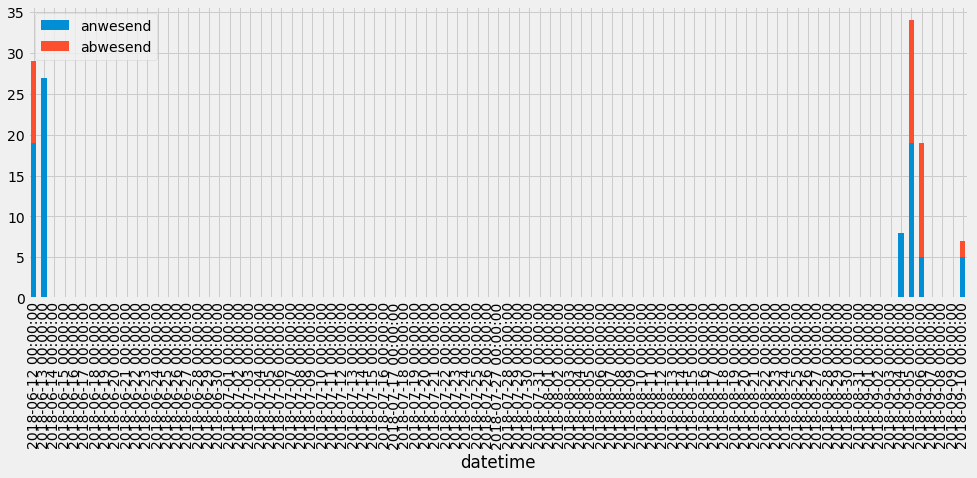

In [92]:
# Todo: Wie sind die Abwesenheiten zeitlich verteilt? 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

anwesend = df_hamdaoui_sp[df_hamdaoui_sp['stimme'] != 'abwesend'].set_index('datetime').resample('D')['stimme'].count()
abwesend = df_hamdaoui_sp[df_hamdaoui_sp['stimme'] == 'abwesend'].set_index('datetime').resample('D')['stimme'].count()
df_temp = pd.merge(anwesend, abwesend, left_index=True, right_index=True)
df_temp.columns = ['anwesend', 'abwesend']

fig, ax = plt.subplots(figsize=[15,5])
df_temp.plot(kind='bar', stacked=True, ax=ax)

**Fazit:** Hamdaoui stimmte während der SP-Zeit zu 97 Prozent mit seiner Fraktion. Allerdings war er bei 22 Prozent der ausgewerteten Abstimmungen nicht anwesend. Offenbar fehlte er an drei Tagen teilweise.

In [93]:
# Wie linentreu stimmte Hamdaoui als Mitglied der Mitte-Fraktion? 

# Aufbereiten der Daten.  
temp_dict = dict()
for i, r in df_parteilinie.iterrows():
    try:
        parteilinie = r['Die Mitte']
        hamadaouilinie = df_hamdaoui_mitte[(df_hamdaoui_mitte['geschäftsname'] == i[0]) & 
                                        (df_hamdaoui_mitte['dateiname'] == i[1]) &
                                        (df_hamdaoui_mitte['register'] == i[2])]['stimme'].iloc[0]
        temp_dict[i] = parteilinie, hamadaouilinie
    except: 
        pass
    
df_hamdaoui_mitte_auswertung = pd.DataFrame.from_dict(temp_dict, orient='index')
df_hamdaoui_mitte_auswertung['linientreu'] = ''

for i, r in df_hamdaoui_mitte_auswertung[(df_hamdaoui_mitte_auswertung[0] != 'unentschieden') & 
                                         (df_hamdaoui_mitte_auswertung[1] != 'abwesend')].iterrows():
    if r[0] == r[1]:
        df_hamdaoui_mitte_auswertung.at[i, 'linientreu'] = True
    elif r[0] != r[1]:
        df_hamdaoui_mitte_auswertung.at[i, 'linientreu'] = False
        
df_hamdaoui_mitte_auswertung

,0,1,linientreu
"(#0000.0000_0, Frühlingssession 2019.xlsx, 4.03.2019)",ja,nein,False
"(#0000.0000_0, Frühlingssession 2020.xlsx, 2.03.2020)",ja,ja,True
"(#0000.0000_0, Frühlingssession 2020.xlsx, 4.03.2020)",nein,ja,False
"(#0000.0000_0, Herbstsession 2019.xlsx, 2.09.2019)",ja,ja,True
"(#0000.0000_0, Wintersession 2019.xlsx, 2.12.2019)",unentschieden,ja,
...,...,...,...
"(Ordnungsantrag / Motion d’ordre 3_1, 01) 08.03.21 Frühlingssession 2021.xlsx, Tabelle3)",nein,enthaltung,False
"(Ordnungsantrag / Motion d’ordre 4_1, 01) 08.03.21 Frühlingssession 2021.xlsx, Tabelle4)",nein,enthaltung,False
"(Ordnungsantrag / Motion d’ordre 5_1, 01) 08.03.21 Frühlingssession 2021.xlsx, Tabelle5)",ja,ja,True
"(Ordnungsantrag / Motion d’ordre 6_1, 01) 08.03.21 Frühlingssession 2021.xlsx, Tabelle6)",nein,nein,True


In [94]:
# In relativen Werten. 
df_temp = df_hamdaoui_mitte_auswertung['linientreu'].value_counts().to_frame()
df_temp = df_temp[df_temp.index != '']
df_temp['rel'] = 100 * df_temp['linientreu'] / df_temp['linientreu'].sum()
df_temp

,linientreu,rel
True,826,66.132906
False,423,33.867094


**Fazit:** Hamdaoui stimmt bloss in rund zwei Drittel der Abstimmungen mit seinen Kolleginnen und Kollegen der Mitte-Fraktion.  

In [ ]:
# Wie oft hat Hamdaoui 'Ja' bzw. 'Nein' gestimmt? Wie oft hat er sich enthalten? Wie oft war er abwesend? 
# Die Auswertung ist aufgeteilt nach SP-Zeit und Mitte-Zeit. 
df_temp = df_hamdaoui_sp_auswertung[1].value_counts().to_frame()
df_temp = pd.merge(df_temp, df_hamdaoui_mitte_auswertung[1].value_counts().to_frame(), left_index=True, right_index=True)
df_temp.columns = ['sp', 'mitte']

for c in df_temp.columns:
    df_temp[c + '_rel'] = 100 * df_temp[c] / df_temp[c].sum()
df_temp

In [ ]:
anwesend = df_hamdaoui_mitte[df_hamdaoui_mitte['stimme'] != 'abwesend'].set_index('datetime').resample('D')['stimme'].count()
abwesend = df_hamdaoui_mitte[df_hamdaoui_mitte['stimme'] == 'abwesend'].set_index('datetime').resample('D')['stimme'].count()
df_temp = pd.merge(anwesend, abwesend, left_index=True, right_index=True)
df_temp.columns = ['anwesend', 'abwesend']

fig, ax = plt.subplots(figsize=[15,5])
df_temp.plot(kind='bar', stacked=True, ax=ax)

**Fazit:** Hamdaoui ist in der Mitte-Zeit bei rund jeder vierten Abstimmung abwesend. 

In [ ]:
# Todo: Wie hoch sind die Abwesenheitswerte des mittleren Parlamentariers? 

In [ ]:
# Wäre Hamadoui weiterhin besser bei der SP als bei der FDP aufgehoben? 

# Aufbereiten der Daten.  
temp_dict = dict()
for i, r in df_parteilinie.iterrows():
    try:
        parteilinie = r['SP']
        hamadaouilinie = df_hamdaoui_mitte[(df_hamdaoui_mitte['geschäftsname'] == i[0]) & 
                                        (df_hamdaoui_mitte['dateiname'] == i[1]) &
                                        (df_hamdaoui_mitte['register'] == i[2])]['stimme'].iloc[0]
        temp_dict[i] = parteilinie, hamadaouilinie
    except: 
        pass
    
df_temp = pd.DataFrame.from_dict(temp_dict, orient='index')
df_temp['linientreu'] = ''

for i, r in df_temp[(df_temp[0] != 'unentschieden') &
                    (df_temp[1] != 'abwesend')].iterrows():
    if r[0] == r[1]:
        df_temp.at[i, 'linientreu'] = True
    elif r[0] != r[1]:
        df_temp.at[i, 'linientreu'] = False
        
df_temp

In [ ]:
# In relativen Werten. 
df_temp = df_temp['linientreu'].value_counts().to_frame()
df_temp = df_temp[df_temp.index != '']
df_temp['rel'] = 100 * df_temp['linientreu'] / df_temp['linientreu'].sum()
df_temp

**Fazit:** Hamdaoui hat auch nach seinem Wechsel in die Mitte eine grössere Übereinstimmung mit der SP. Sie ist mit rund 85 Prozent zwar tiefer als zu SP-Zeiten, aber bedeutend höher als die Übereinstimmung mit der Mitte. 

#### Erich Hess

In [ ]:
# Bei welchen Geschäften wich Erich Hess von der Parteilinie ab? 
df_hess = df[(df['vorname'] == 'Erich') & (df['nachname'] == 'Hess')]
df_hess = df_hess[['datetime', 'geschäftsname', 'stimme', 'res_ja', 'res_nein', 'res_enthaltung', 'res_keine_stimme', 'dateiname', 'register']]

df_hess = pd.merge(df_hess, df_parteilinie[['SVP']], left_on=['geschäftsname', 'dateiname', 'register'], right_index=True, how='left')

def hesslinie(stimme, svp):
    if (svp == 'ja' or svp == 'nein' or svp == 'enthaltung') and (stimme == 'ja' or stimme == 'nein' or stimme == 'enthaltung'):
        if stimme == svp: 
            return True
        elif stimme != svp:
            return False

for i, r in df_hess.iterrows(): 
    df_hess.at[i, 'auf_parteilinie'] = hesslinie(r['stimme'], r['SVP'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df_hess[df_hess['auf_parteilinie'] == False]

In [ ]:
# Zur Kontrolle: Wie hoch ist die Linientreue von Hess (in Prozent)
df_temp = df_hess['auf_parteilinie'].value_counts().to_frame().transpose()
df_temp['linientreu_prozent'] = 100 * df_temp[True] / df_temp.sum(axis=1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 50)
df_temp

#### Michel Seiler
Michel Seiler wurde für die Grünen in den Rat gewählt. Er ist Ende Februar 2021 [aus der Partei ausgetreten](https://www.derbund.ch/michel-seiler-verlaesst-berner-gruene-aus-protest-823833957417) und politisiert nun als Parteiloser. Ausschlaggebend war nach seinen Auskünften ein bestimmtes Geschäft. Doch gab es nicht auch zuvor viele Meinungsunterschiede mit den Grünen? 

In [96]:
# Bis wann wird Seiler in den Daten als Grüner aufgeführt?
df_seiler = pd.read_csv('daten/be_grossrat_abstimmungen.csv', index_col='Unnamed: 0', low_memory=False)
df_seiler['datetime'] = pd.to_datetime(df_seiler['datetime'])
df_seiler = df_seiler[(df_seiler['nachname'] == 'Seiler') & (df_seiler['vorname'] == 'Michel')]
df_seiler[df_seiler['partei'] == 'Grüne'].sort_values(by=['datetime'])['datetime'].iloc[-1].date()

datetime.date(2020, 12, 3)

In [97]:
# Seit wann ist Michel Seiler in den Daten als fraktionslos aufgeführt? 
df_seiler[df_seiler['partei'] == 'fraktionslos'].sort_values(by=['datetime'])['datetime'].iloc[0].date()

datetime.date(2021, 3, 8)

In [100]:
# Politisierte Seiler auf Fraktionslinie? 
df_temp_grüne = df_seiler[df_seiler['partei'] == 'Grüne']

# Berechnung: Wie oft politisierte er während der Grünen-Zeit auf Parteilinie?
linientreu = 0
abweichler = 0

for i, r in df_temp_grüne.iterrows():
    if r['stimme'] == 'abwesend':
        pass
    elif r['stimme'] == df_parteilinie.loc[r['geschäftsname'], r['dateiname'], r['register']]['Grüne']:
        linientreu += 1
    else:
        abweichler += 1

print('Zeit als Mitglied der Grünen')
print('linientreu:', linientreu)
print('abweichend:', abweichler)
print('Linientreue in Prozent:', 100 * linientreu / (linientreu + abweichler))

Zeit als Mitglied der Grünen
linientreu: 1396
abweichend: 336
Linientreue in Prozent: 80.60046189376443


In [103]:
df_temp_fraktionslos = df_seiler[df_seiler['partei'] == 'fraktionslos']
linientreu = 0
abweichler = 0

for i, r in df_temp_fraktionslos.iterrows():
    try:
        if r['stimme'] == 'abwesend':
            pass
        elif r['stimme'] == df_parteilinie.loc[r['geschäftsname'], r['dateiname'], r['register']]['Grüne']:
            linientreu += 1
        else:
            abweichler += 1
    except:
        print('Problem bei', i)
print('\n\nZeit als Fraktionsloser')
print('linientreu mit der Ex-Fraktion:', linientreu)
print('abweichend von der Ex-Fraktion:', abweichler)
print('Linientreue mit Ex-Fraktion in Prozent:', 100 * linientreu / (linientreu + abweichler))


Problem bei 292414
Problem bei 295816
Problem bei 304079
Problem bei 306671
Problem bei 312666
Problem bei 315096
Problem bei 319955
Problem bei 324654
Problem bei 330322
Problem bei 330476
Problem bei 330636
Problem bei 330790
Problem bei 330950
Problem bei 331104
Problem bei 331264
Problem bei 331426
Problem bei 331588
Problem bei 331744
Problem bei 331902
Problem bei 332064
Problem bei 332226
Problem bei 332388
Problem bei 332550
Problem bei 332712
Problem bei 332874
Problem bei 333036
Problem bei 333198
Problem bei 333360
Problem bei 333522
Problem bei 333684
Problem bei 333846
Problem bei 334008
Problem bei 334170
Problem bei 334332
Problem bei 334494
Problem bei 334656
Problem bei 334818
Problem bei 334980
Problem bei 335142
Problem bei 336764
Problem bei 337736
Problem bei 339842
Problem bei 341138
Problem bei 342272
Problem bei 343931
Problem bei 346646
Problem bei 348590
Problem bei 350212
Problem bei 350696
Problem bei 351668
Problem bei 352803
Problem bei 353451
Problem bei 

In [ ]:
# Bei welchen Geschäften wich Seiler als Grüner von der Fraktionslinie ab?
for i, r in df_temp_grüne.iterrows():
    if r['stimme'] != 'abwesend' and r['stimme'] != df_parteilinie.loc[r['geschäftsname'], r['dateiname'], r['register']]['Grüne']:
        print(r['geschäftsname'] + ' | ' + r['dateiname'] + ' | ' + r['register'])

In [ ]:
# Bei welchen Geschäften wich Seiler als Fraktionsloser von der Linie seiner ehemaligen Fraktion ab?
for i, r in df_temp_franktionslos.iterrows():
    if r['stimme'] != 'abwesend' and r['stimme'] != df_parteilinie.loc[r['geschäftsname'], r['dateiname'], r['register']]['Grüne']:
        print(r['geschäftsname'] + ' | ' + r['dateiname'] + ' | ' + r['register'])

#### Christoph Zimmerli
Hier werden die Informationen zu Christoph Zimmerli (FDP) nochmals geprüft. 

In [55]:
# Wie oft hat Christoph Zimmerli (FDP) abgesimmt? 
df_zimmerli = df[(df['nachname'] == 'Zimmerli') & (df['vorname'] == 'Christoph')]
len(df_zimmerli[df_zimmerli['stimme'].isin(['ja', 'nein', 'enthaltung'])])

2016

In [56]:
# Wie oft war Christoph Zimmerli abwesend?
len(df_zimmerli[df_zimmerli['stimme'].isin(['abwesend'])])

183

In [57]:
# Wie oft weicht Zimmerli von der Parteilinie ab? 
abstimmungen = 0
mit_fraktion = 0
gegen_fraktion = 0

for i, r in df_zimmerli[df_zimmerli['stimme'].isin(['ja', 'nein', 'enthaltung'])].iterrows():
    parteilinie = df_parteilinie.loc[r['geschäftsname'], r['dateiname'], r['register']]['FDP']
    if parteilinie == 'unentschieden':
        pass
    elif r['stimme'] == parteilinie:
        mit_fraktion += 1
    elif r['stimme'] != parteilinie:
        gegen_fraktion += 1
print('Anzahl Abstimmungsteilnahmen:', len(df_zimmerli[df_zimmerli['stimme'].isin(['ja', 'nein', 'enthaltung'])]))
print('Mit der Frakion:', mit_fraktion)
print('Gegen die Frakion:', gegen_fraktion)
print('Enthaltungen:', len(df_zimmerli[df_zimmerli['stimme'] == 'enthaltung']))
print('Prozent:', 100 * mit_fraktion / (mit_fraktion + gegen_fraktion))

Anzahl Abstimmungsteilnahmen: 2016
Mit der Frakion: 1955
Gegen die Frakion: 15
Enthaltungen: 3
Prozent: 99.23857868020305
